# Collaborative Filtering Recommendation System
* Building a Product Recommendation Engine
* Import Libraries and Setup

In [44]:
# Import libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithZScore, NormalPredictor
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import GridSearchCV, cross_validate
from IPython.display import display, HTML
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from scipy import stats
import random

## Data Loading and Initial Exploration
This section loads the data and performs initial checks on the dataset as well as preenting data type related issues to improve performance. All of the reviews are combined to have as much data as we can.

In [2]:
# Define the data loading function
def load_data():
    project_root = os.getcwd()
    datasets = os.path.join(project_root, "datasets/")
    
    # Define the dtype for both author_id and product_id to avoid mixed types
    dtype_dict = {
        'author_id': str,
        'product_id': str
    }
    
    # Load product info and reviews
    product_info = pd.read_csv(os.path.join(datasets, "product_info.csv"), dtype=dtype_dict)
    reviews_files = [
        "reviews_0-250.csv", "reviews_250-500.csv", 
        "reviews_500-750.csv", "reviews_750-1250.csv", 
        "reviews_1250-end.csv"
    ]
    
    all_reviews = []
    for file in reviews_files:
        reviews = pd.read_csv(os.path.join(datasets, file), dtype=dtype_dict)
        all_reviews.append(reviews)
    
    # Concatenate all reviews and remove duplicates
    all_reviews = pd.concat(all_reviews, ignore_index=True).drop_duplicates()
    
    return product_info, all_reviews


# Load the data
product_info, all_reviews = load_data()

# Display basic information about the datasets
print("Product Info Shape:", product_info.shape)
print("All Reviews Shape:", all_reviews.shape)

# Display sample of product info
display(product_info.head())
display(all_reviews.head())

Product Info Shape: (8494, 27)
All Reviews Shape: (1094411, 19)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


## Data Preprocessing
This section handles missing values and prepares the data for model training.

The following are the variables that we will be working with for the reccommendation model and improve its predictive power. These columns can help the recommendation system better understand user preferences and product characteristics. These variables have no missing values. `product_id` can be linked between the two datasets.

#### Product Info
    product_id
    product_name
    brand_name


#### Reviews
    author_id
    product_id
    rating

In [33]:
# Review the two datasets
datasets = os.path.join("datasets/")
product_info_indexed = pd.read_csv(datasets + "product_info.csv", index_col="product_id")
product_cols = product_info[['product_id', 'product_name', 'brand_name']].sample(n=100, random_state=1).head()
reviews_rows = all_reviews[['author_id', 'product_id', 'rating']].sample(n=100, random_state=1).head()

display(HTML(
    f"""
    <div style="display: flex; justify-content: center;">
        <div style="margin-right: 30px;">
            <h3>Product Info</h3>
            {product_cols.to_html(index=False)}
            <br />
            <h3>Reviews</h3>
            {reviews_rows.to_html(index=False)}
        </div>
    </div>
    """
))

product_id,product_name,brand_name
P375375,Angled Liner Brush,Hourglass
P434429,Resistance Strengthening Conditioner for Damaged Hair,Kérastase
P502169,Barrier+ Besties Hydrating and Nourishing Kit,Skinfix
P483092,Glow Peel Pads with AHA + PHA,SEPHORA COLLECTION
P471261,Daisy Eau So Intense Eau de Parfum,Marc Jacobs Fragrances
author_id,product_id,rating
37301111097,P500121,2
5138189587,P454838,4
811891666,P481335,5
22214579608,P467762,4


#### Create a sample Matrix (summarizes all reviews across all products)

The following table shows which products have been rated by which users; use pandas pivot table (takes a list of data and summarizes it with one row (for ea unique user) and one column (for ea unique product) in the dataset.
- 1 row per user
- 1 column per product

In [27]:
# Sample 100 rows from the all_reviews DataFrame
sampled_all_reviews = all_reviews.sample(n=100, random_state=1)

# Create your pivot table from the sampled data
sample_df = pd.pivot_table(sampled_all_reviews, index='author_id', columns='product_id', values='rating', aggfunc='max', fill_value="")

# Create a CSV file of the sampled data
sample_df.to_csv("review_matrix_sampled.csv", na_rep="")
sample_df

product_id,P122762,P122774,P12336,P201440,P218700,P270594,P278317,P297524,P375534,P381030,...,P484080,P500121,P500288,P500894,P501421,P503250,P504042,P504045,P504320,P504986
author_id,,,,,,,,,,,,,,,,,,,,,
1004216492,,,,4,,,,,,,...,,,,,,,,,,
10624026829,,,,,,,,,,,...,,,,,,,,,,
1078393772,,,,,,,,,,,...,,,,,,,,,,
1121421989,,,,,,,,,,,...,,,,,,,,,5,
11366017341,,,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811891666,,,,,,,,,,,...,,,,,,,,,,
8477019138,,,,,,,,,,,...,,,,,,,,,,
8639995150,,,,,,,,,,,...,,,,,,,,,,


This matrix shows that a majority of potential interactions or values are absent. Algorithms of the Surprise library like k-nearest neighbors (KNN) and matrix factorization techniques are designed to handle these sparse datasets effectively.

Data normalization was implemented to enhance the performance of the recommendation model by adjusting for users who consistently rate products lower or higher than others. This helps reduce bias, resulting in more accurate and fair recommendations. However, the KNN algorithms in the Surprise library offer built-in normalization which is why the ratings will be bounded in the 1 to 5 range.

The provided normalization function employs mean centering, which adjusts each user's ratings by subtracting their average rating from their individual ratings. This results in normalized ratings that typically range around -1 to 1, depending on the variability of each user's ratings. Users who rate items similarly will have normalized ratings close to zero, while those with a wider range of ratings will show greater variability, possibly extending beyond -1 and 1.

In [3]:
# Define normalization function
def normalize_ratings(df, method='mean_center'):
    if method == 'mean_center':
        # Subtract each user's mean rating from their ratings
        user_means = df.groupby('author_id')['rating'].transform('mean')
        df['normalized_rating'] = df['rating'] - user_means
    else:
        raise ValueError("Invalid normalization method. Only 'mean_center' is supported.")
    
    return df

The user IDs are string data types so to improve efficiency, we are transforming those to integer indices

In [4]:
# Define preprocessing methods
def preprocess_data(product_info, all_reviews):
    # Merge product info with reviews
    merged_df = all_reviews.merge(
        product_info[['product_id', 'product_name', 'brand_name']], 
        on='product_id', 
        how='left'
    )
    
    # Check for missing values
    print("Missing values:")
    print(merged_df.isnull().sum())
    
    # Create mapping dictionaries for users and items
    user_mapper = {id_: idx for idx, id_ in enumerate(merged_df['author_id'].unique())}
    item_mapper = {id_: idx for idx, id_ in enumerate(merged_df['product_id'].unique())}
    
    # Create reverse mappers
    reverse_user_mapper = {v: k for k, v in user_mapper.items()}
    reverse_item_mapper = {v: k for k, v in item_mapper.items()}
    
    # Transform IDs to numerical indices
    merged_df['user_idx'] = merged_df['author_id'].map(user_mapper)
    merged_df['item_idx'] = merged_df['product_id'].map(item_mapper)
    
    return merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper

# Preprocess the data
merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper = preprocess_data(product_info, all_reviews)

Missing values:
Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name_x                   0
brand_name_x                     0
price_usd                        0
product_name_y                   0
brand_name_y                     0
dtype: int64


When using the Surprise library, having complete records for the key columns `product_id`, `author_id`, and `rating` is sufficient. We don’t need to handle missing values in irrelevant columns, as Surprise only requires the key columns for building and training recommendation models.

## Exploratory Data Analysis
This section prepare visualizations to gain preliminary insights into the data.

* Examine the distribution of ratings
* Identify which skincare brand has the highest number of ratings
* Analyze the average number of reviews each user typically leaves

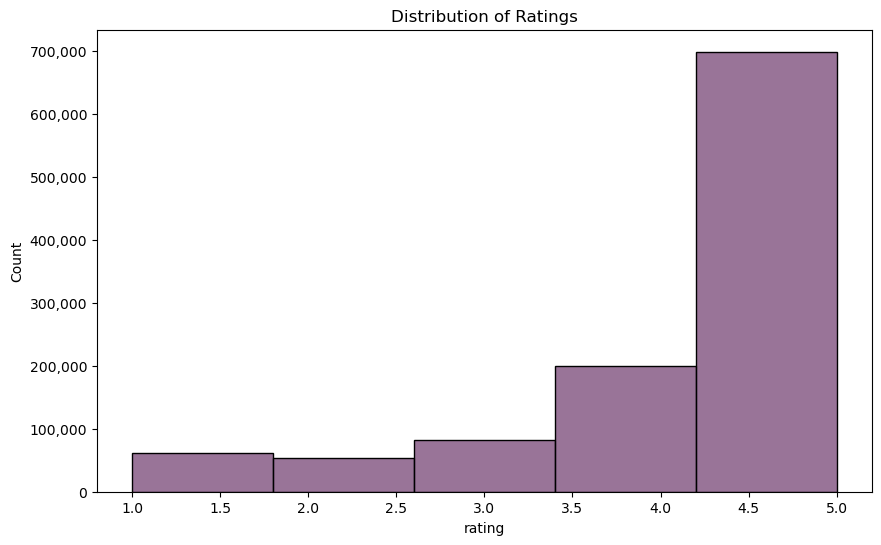


Rating Statistics:
count    1.094411e+06
mean     4.299158e+00
std      1.149444e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [45]:
# 1. Rating Distribution
def comma_formatter(x, _):
    return f'{int(x):,}'

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['rating'], bins=5, color='#774576')
plt.title('Distribution of Ratings')
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.show()

print("\nRating Statistics:")
print(merged_df['rating'].describe())

The majority of users rate products high (4s or 5s).

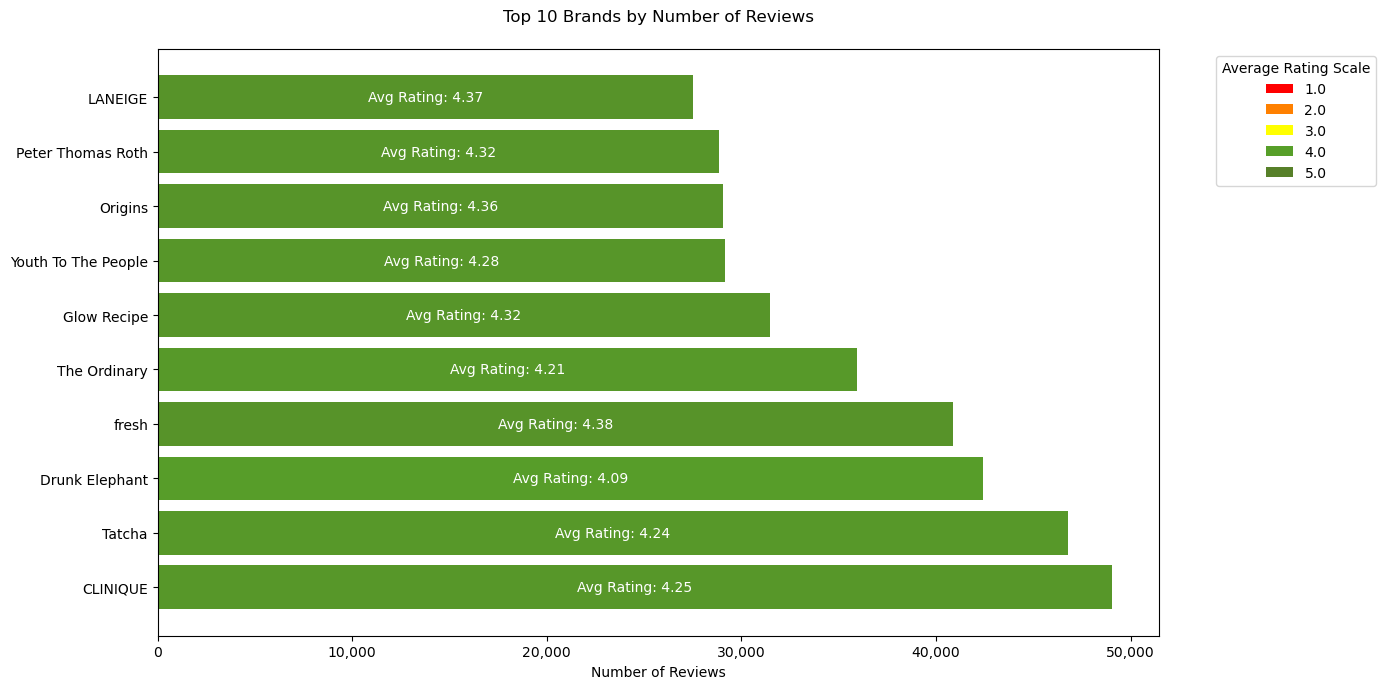

In [49]:
# Calculate average ratings and get top 10 brands by review count
top_brands_df = (merged_df.groupby('brand_name_x')['rating']
                 .agg(['mean', 'count'])
                 .nlargest(10, 'count')
                 .reset_index()
                 .rename(columns={'mean': 'avg_rating', 'count': 'review_count'}))

# Define color mapping based on average rating
def rating_to_color(rating):
    normalized = (rating - 1) / 4  # Map rating 1-5 to 0-1 for color range
    if normalized <= 0.5:
        # Red to Yellow
        return (1.0, 2 * normalized, 0.0)  # RGB values in [0, 1]
    else:
        # Yellow to Dark Green
        return (0.34, 0.5 + 0.5 * (1 - normalized), 0.16)  # dark green RGB values

# Generate colors based on ratings
colors = [rating_to_color(rating) for rating in top_brands_df['avg_rating']]

# Plot bar chart
plt.figure(figsize=(14, 7))
bars = plt.barh(top_brands_df['brand_name_x'], top_brands_df['review_count'], color=colors)

# Annotate bars with average rating inside
for bar, avg_rating in zip(bars, top_brands_df['avg_rating']):
    plt.text(bar.get_width() / 2,  # Center the text horizontally in the bar
             bar.get_y() + bar.get_height()/2,  # Center the text vertically
             f'Avg Rating: {avg_rating:.2f}', 
             ha='center',  # Horizontal alignment
             va='center',  # Vertical alignment
             color='white',  # Text color
             fontsize=10)   # Font size

# Title and labels
plt.title('Top 10 Brands by Number of Reviews', pad=20)
plt.xlabel('Number of Reviews')

# Color legend for rating scale
legend_elements = [patches.Patch(facecolor=rating_to_color(r), label=f'{r}.0') for r in range(1, 6)]
plt.legend(handles=legend_elements, title='Average Rating Scale', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.tight_layout()
plt.show()

CLINIQUE and Tatcha are reviewed frequently.

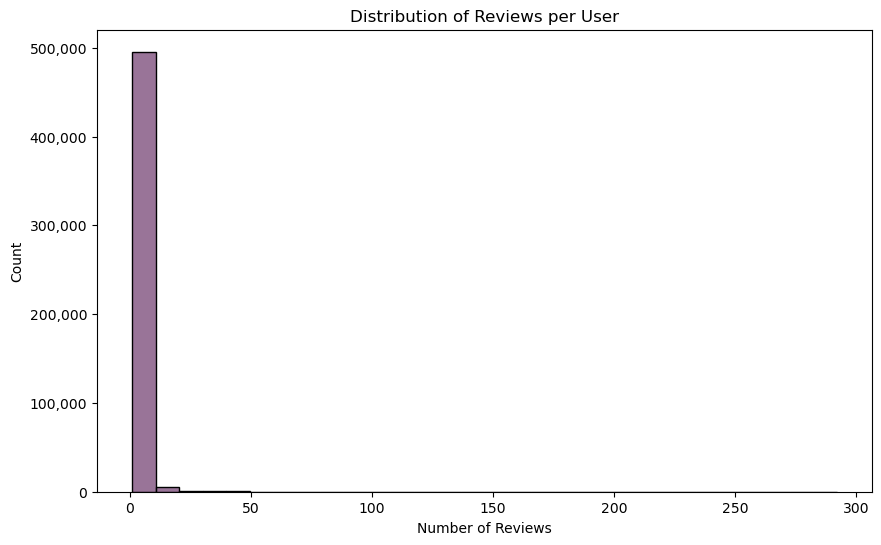


User Activity Statistics:
count    503216.000000
mean          2.174833
std           3.414628
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         292.000000
dtype: float64


In [48]:
# 3. User Activity Analysis
user_activity = merged_df.groupby('author_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=30, color='#774576')
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.show()
    
print("\nUser Activity Statistics:")
print(user_activity.describe())

Most customers who leave reviews on the Sephora website typically submit just one review. However, some users have posted as many as 292 reviews.

Use the Reader class in the Surprise library for parsing and reading the rating data. I have indicated that the ratings can range from 1 to 5. This helps in training algorithms and validating predictions.

A subset is created from the `merged_df` dataset, containing user-item interactions and their ratings. This subset is then loaded into a format that the Surprise library can understand for training recommendation models. The `data` variable is defined as a Surprise Dataset object that can be used with various algorithms for collaborative filtering, matrix factorization, or other recommendation techniques.

## Model Training and Evaluation
* This section prepares the data for the Surprise library and trains multiple models to create a similarity matrix.
* We will be trying different algorithms (SVD, KNNWithZScore, KNNBasic, and NormalPredictor) to compare performance
* These models compute similarities between items or users, similar to collaborative filtering.
* Each model instance will be implemented with varying hyperparameters.

**SVD (Singular Value Decomposition):** a matrix factorization technique used in collaborative filtering. It decomposes the user-item interaction matrix into three matrices: user features, item features, and singular values. It predicts user preferences by approximating the original matrix with these decomposed matrices, capturing latent factors that explain the observed ratings.

**KNNWithZScore:** a k-nearest neighbors (k-NN) algorithm that incorporates z-score normalization. In other words, it automatically normalizes the data by converting the ratings into z-scores so we do not have to in preprocessing. It adjusts ratings by subtracting the mean and dividing by the standard deviation of each user’s ratings. It computes similarities between users or items based on these normalized ratings, making predictions by aggregating the ratings of the nearest neighbors.

**KNNBasic:** a straightforward k-NN algorithm for collaborative filtering. It computes the similarity between users or items and uses these similarities to predict ratings. The prediction is made by taking a weighted average of the ratings from the most similar users or items.

**NormalPredictor:** a baseline algorithm that predicts ratings randomly based on the distribution of the training set. It assumes the ratings follow a normal distribution. It generates predictions by sampling from this normal distribution, providing a simple benchmark for comparing other algorithms

In [8]:
# Model Training and Evaluation

def train_and_evaluate_base_models(merged_df):
    # Prepare normalized data for SVD and NormalPredictor
    normalized_df = normalize_ratings(merged_df.copy())
    reader_normalized = Reader(rating_scale=(normalized_df['normalized_rating'].min(), normalized_df['normalized_rating'].max()))
    data_normalized = Dataset.load_from_df(normalized_df[['user_idx', 'item_idx', 'normalized_rating']], reader_normalized)
    
    # Prepare unnormalized data for KNNWithZScore and KNNBasic
    reader_unnormalized = Reader(rating_scale=(1, 5))
    data_unnormalized = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader_unnormalized)
    
    # Split into training and test set
    base_trainset_normalized, base_testset_normalized = surprise_train_test_split(data_normalized, test_size=0.25, random_state=42)
    base_trainset_unnormalized, base_testset_unnormalized = surprise_train_test_split(data_unnormalized, test_size=0.25, random_state=42)
    
    # Initialize base_models
    base_models = {
        'SVD': SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02),
        'KNNWithZScore': KNNWithZScore(sim_options={'name': 'pearson_baseline', 'user_based': False}, k=40),
        'KNNBasic': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}, k=30),
        'NormalPredictor': NormalPredictor()
    }
    
    # Train and evaluate each model
    base_results = {}
    for name, model in base_models.items():
        print(f"\nTraining {name}...")
        if name in ['KNNWithZScore', 'KNNBasic']:
            # Use unnormalized data for KNN models
            model.fit(base_trainset_unnormalized)
            predictions = model.test(base_testset_unnormalized)
        else:
            # Use normalized data for other models
            model.fit(base_trainset_normalized)
            predictions = model.test(base_testset_normalized)
        base_results[name] = predictions
    
    return base_results, base_trainset_normalized, base_testset_normalized, base_models

# Train and evaluate base models
base_results, base_trainset, base_testset, base_models = train_and_evaluate_base_models(merged_df)


Training SVD...

Training KNNWithZScore...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Training KNNBasic...
Computing the cosine similarity matrix...
Done computing similarity matrix.

Training NormalPredictor...


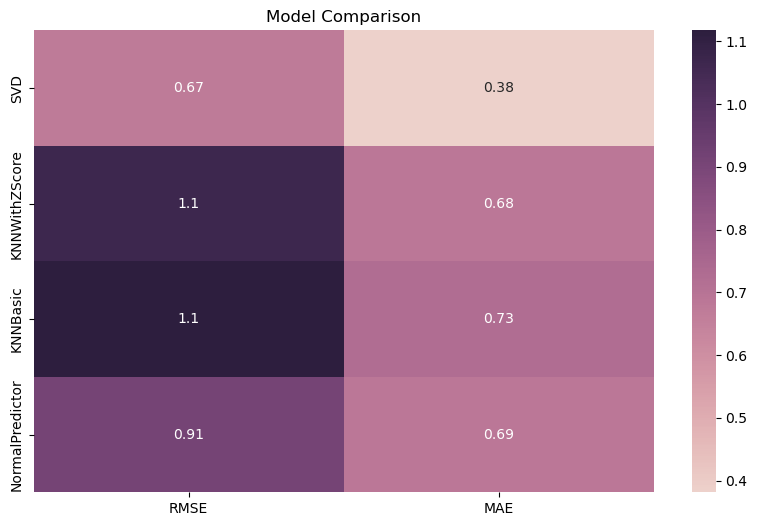

Best parameters: {'n_factors': 50, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}
Best RMSE: 0.6434396905207401


In [35]:
def compare_base_models(base_results):
    base_model_metrics = {}
    for name, predictions in base_results.items():
        rmse = np.sqrt(np.mean([(p.r_ui - p.est) ** 2 for p in predictions]))
        mae = np.mean([abs(p.r_ui - p.est) for p in predictions])
        base_model_metrics[name] = {'RMSE': rmse, 'MAE': mae}
    
    base_metrics = pd.DataFrame(base_model_metrics).T
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(base_metrics, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title('Model Comparison')
    plt.show()
    
    return base_metrics

# Compare models
base_metrics = compare_base_models(base_results)

# Hyperparameter tuning for the best model
def tune_best_model(data):
    base_param_grid = {
        'n_factors': [50, 100],
        'n_epochs': [5, 10],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6]
    }
    
    gs = GridSearchCV(SVD, base_param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    
    print("Best parameters:", gs.best_params['rmse'])
    print("Best RMSE:", gs.best_score['rmse'])
    
    return gs.best_params['rmse']

# Tune the best model
# Rationale: We use normalized data for SVD tuning as it performed better in initial tests
normalized_df = normalize_ratings(merged_df.copy())
reader = Reader(rating_scale=(normalized_df['normalized_rating'].min(), normalized_df['normalized_rating'].max()))
data = Dataset.load_from_df(normalized_df[['user_idx', 'item_idx', 'normalized_rating']], reader)
base_params = tune_best_model(data)

    Best parameters: {'n_factors': 50, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}
    Best RMSE: 0.6434240706527333

SVD has the lowest mean absolute error, outperforming the rest of the models.

In [10]:
# Display the first 5 predictions generated
first_five = base_results['SVD'][:5]

first_preds = [{
    'user_id': pred.uid,
    'item_id': pred.iid,
    'actual_rating': pred.r_ui,
    'estimated_rating': pred.est
} for pred in first_five]

# Create a DataFrame
five_preds = pd.DataFrame(first_preds)
five_preds

,user_id,item_id,actual_rating,estimated_rating
0,62051,9,0.0,0.117951
1,60554,144,1.0,0.103985
2,423488,547,0.0,0.203120
3,186131,61,-0.5,0.175898
4,235961,783,0.2,0.061004


After training the model, it predicts the rating a user would give to a specific item on a scale from -1 to 1 or 1 to 5 (depending on data normalization requirements of the models), based on their past behavior and the behavior of similar users or items. 

since the SVD used normalized data, users who rate items similarly will have normalized ratings close to zero, while those with a wider range of ratings will show greater variability, possibly extending beyond -1 and 1.

* The user with ID 62051 had the best prediction, with an actual rating of 0.0 and an estimated rating of -0.123681, resulting in an error of 0.123681.
* The user with ID 60554 had the worst prediction, with an actual rating of 1.0 and an estimated rating of -0.089657, resulting in a significantly larger error of 1.089657.

For a more interpretable comparison with later models, we will analyze KNNWithZScore which used a non normalized training set because the Surprise library has an internal normalization method for this model.

In [11]:
# Display the first 5 predictions generated
first_five_knn = base_results['KNNWithZScore'][:5]

first_preds_knn = [{
    'user_id': pred.uid,
    'item_id': pred.iid,
    'actual_rating': pred.r_ui,
    'estimated_rating': pred.est
} for pred in first_five_knn]

# Create a DataFrame
five_preds_knn = pd.DataFrame(first_preds_knn)
five_preds_knn

,user_id,item_id,actual_rating,estimated_rating
0,62051,9,5.0,5.000000
1,60554,144,5.0,3.805675
2,423488,547,5.0,4.298982
3,186131,61,1.0,2.311481
4,235961,783,5.0,4.727081


Like SVD, 62051 had the best prediction, but this time, 186131 had the worst prediction. We can observe that 186131 has lowly rated a product.

## Model Comparison and Hyperparameter Tuning
This section compares different models and performs hyperparameter tuning for the best model. We will train models using cross-validation for hyperparameter tuning.

**SVD Hyperparameters:**

- **n_factors:** The number of latent factors (higher values can capture more complex patterns but may lead to overfitting)
- **n_epochs:** Number of iterations over the training data (more epochs can lead to better convergence but increases training time)
- **lr_all:** Learning rate for all parameters (higher values can lead to faster convergence but may cause instability)
- **reg_all:** Regularization term for all parameters (higher values prevent overfitting but may lead to underfitting)


**KNNWithZScore & KNNBasic Hyperparameters:**

- **sim_options:** Similarity measure (e.g., 'pearson_baseline', 'cosine') and whether to compute similarities between users (True) or items (False)
- **k:** Number of neighbors ( The higher k smooths out predictions but may introduce irrelevant neighbors)

**NormalPredictor Hyperparameters:** None

In [12]:
# Function to train models with cross-validation for hyperparameter tuning
def tune_model_with_cv(data, param_grid, cv=5):
    gs = GridSearchCV(
        SVD,
        param_grid,
        measures=['rmse', 'mae'],
        cv=cv,
        n_jobs=-1,
        joblib_verbose=1
    )
    
    gs.fit(data)
    
    best_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print(f"Best parameters: {best_params}")
    print(f"Best RMSE: {best_score}")
    
    return best_params, pd.DataFrame.from_dict(gs.cv_results)

# Function to train and evaluate base models
def train_and_evaluate_models(merged_df):
    # Normalize ratings for SVD and NormalPredictor
    normalized_df = normalize_ratings(merged_df.copy())
    reader_normalized = Reader(rating_scale=(normalized_df['normalized_rating'].min(), normalized_df['normalized_rating'].max()))
    data_normalized = Dataset.load_from_df(normalized_df[['user_idx', 'item_idx', 'normalized_rating']], reader_normalized)
    
    # Unnormalized data for KNNWithZScore and KNNBasic
    reader_unnormalized = Reader(rating_scale=(1, 5))
    data_unnormalized = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader_unnormalized)
    
    # Define parameter grid for tuning SVD
    param_grid = {
        'n_factors': [50, 100, 150],
        'n_epochs': [10, 20, 30],
        'lr_all': [0.002, 0.005, 0.007],
        'reg_all': [0.02, 0.04, 0.06]
    }
    
    # Perform hyperparameter tuning
    best_params, cv_results = tune_model_with_cv(data_normalized, param_grid)
    
    # Create and evaluate final model
    best_model = SVD(**best_params)
    trainset_normalized = data_normalized.build_full_trainset()
    trainset_unnormalized = data_unnormalized.build_full_trainset()
    
    best_model.fit(trainset_normalized)
    
    # Initialize other models
    models = {
        'SVD': best_model,
        'KNNWithZScore': KNNWithZScore(sim_options={'name': 'pearson_baseline', 'user_based': False}, k=40),
        'KNNBasic': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}, k=30),
        'NormalPredictor': NormalPredictor()
    }
    
    # Train and evaluate each model
    results = {}
    testset_normalized = trainset_normalized.build_testset()
    testset_unnormalized = trainset_unnormalized.build_testset()
    for name, model in models.items():
        if name == 'SVD' or name == 'NormalPredictor':
            model.fit(trainset_normalized)
            predictions = model.test(testset_normalized)
        else:
            model.fit(trainset_unnormalized)
            predictions = model.test(testset_unnormalized)
        results[name] = predictions
    
    return {
        'results': results,
        'models': models,
        'best_params': best_params,
        'cv_results': cv_results
    }

# Train and evaluate models
model_data = train_and_evaluate_models(merged_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 22.2min finished


Best parameters: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.06}
Best RMSE: 0.6485673580010565
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


    Best parameters: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.06}
    Best RMSE: 0.6486193663949551

Visualize and compare the performance of our models with the best parameters.

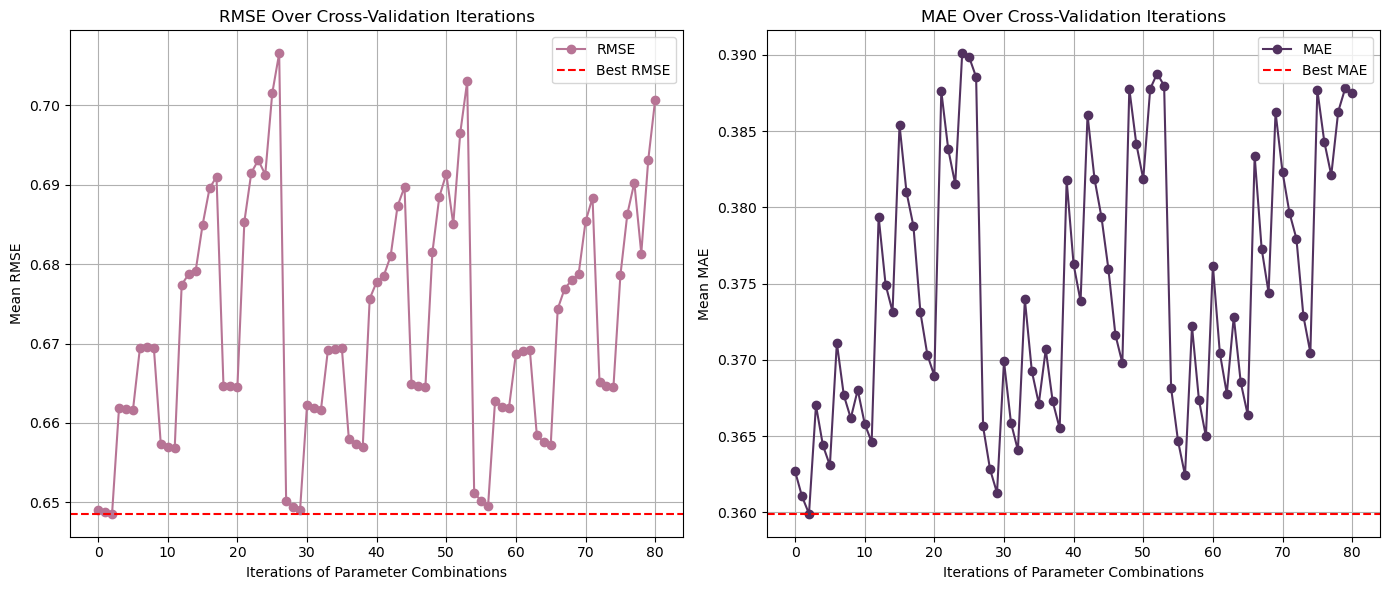

In [55]:
# Function to plot cross-validation results
def plot_cv_results(cv_results):
    plt.figure(figsize=(14, 6))

    # Plot RMSE over iterations
    plt.subplot(1, 2, 1)
    plt.plot(cv_results['mean_test_rmse'], marker='o', color='#b77495', label='RMSE')
    plt.xlabel("Iterations of Parameter Combinations")
    plt.ylabel("Mean RMSE")
    plt.title("RMSE Over Cross-Validation Iterations")
    plt.axhline(y=min(cv_results['mean_test_rmse']), color='r', linestyle='--', label='Best RMSE')  # Add best RMSE line
    plt.legend()
    plt.grid(True)  # Add gridlines
    
    # Plot MAE over iterations
    plt.subplot(1, 2, 2)
    plt.plot(cv_results['mean_test_mae'], marker='o', color='#52315f', label='MAE')
    plt.xlabel("Iterations of Parameter Combinations")
    plt.ylabel("Mean MAE")
    plt.title("MAE Over Cross-Validation Iterations")
    plt.axhline(y=min(cv_results['mean_test_mae']), color='r', linestyle='--', label='Best MAE')  # Add best MAE line
    plt.legend()
    plt.grid(True)  # Add gridlines

    plt.tight_layout()
    plt.show()

# Call the function with cv_results
plot_cv_results(model_data['cv_results'])

The 5-fold cross-validation ensures that the chosen parameters for the models effectively generalize across five equally sized subsets of the data. ~16 (parameter combinations) × 5 (folds) ~ 80 iterations. This approach helps reduce the risk of overfitting to any specific training or validation set by allowing the model to be evaluated on different portions of the data.

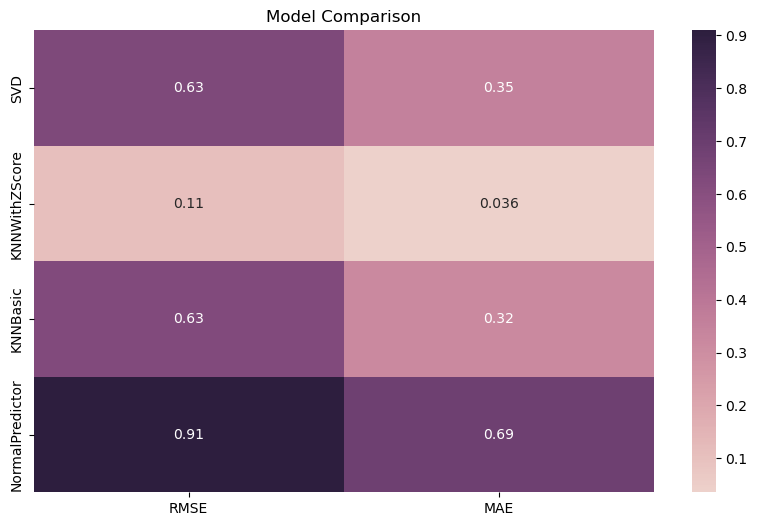

In [36]:
# Compare models
def compare_models(results):
    model_metrics = {}
    for name, predictions in results.items():
        rmse = np.sqrt(np.mean([(p.r_ui - p.est)**2 for p in predictions]))
        mae = np.mean([abs(p.r_ui - p.est) for p in predictions])
        model_metrics[name] = {'RMSE': rmse, 'MAE': mae}
    
    metrics_df = pd.DataFrame(model_metrics).T
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title('Model Comparison')
    plt.show()
    
    return metrics_df

# Compare models
metrics_df = compare_models(model_data['results'])

With the applied best parameters, on average, the KNNWithZScore is off by 0.036. Therefore we will use it as the best model.

In [15]:
specific_user_ids = [60554]
# specific_user_ids = [62051, 60554, 423488, 186131, 235961]

# Filter predictions to include only those for the specified user IDs
filtered_predictions = [pred for pred in model_data['results']['KNNWithZScore'] if pred.uid in specific_user_ids]

# Extract relevant information for each prediction
user_predictions = [{
    'user_id': pred.uid,
    'item_id': pred.iid,
    'actual_rating': pred.r_ui,
    'estimated_rating': pred.est
} for pred in filtered_predictions]

# Create a DataFrame from the filtered predictions
df_predictions = pd.DataFrame(user_predictions)
df_predictions

,user_id,item_id,actual_rating,estimated_rating
0,60554,9,3.0,3.000000
1,60554,61,4.0,4.008766
2,60554,144,5.0,4.992797


Previously, the base model provided a poor estimate for user_id 186131's rating of item 61. With hyperparameter tuning, lets see how the estimate has improved.

In [16]:
specific_user_ids = [186131]

# Display the first 5 predictions generated by the base KNNWithZScore model
before_hpt = pd.DataFrame([{
    'user_id': pred.uid,
    'item_id': pred.iid,
    'actual_rating': pred.r_ui,
    'estimated_rating': pred.est
} for pred in base_results['KNNWithZScore'] if pred.uid in specific_user_ids])

# Filter predictions for specific user IDs after hyperparameter tuning

after_hpt = [
    {'user_id': pred.uid, 
     'item_id': pred.iid, 
     'actual_rating': pred.r_ui, 
     'estimated_rating': pred.est
}
for pred in model_data['results']['KNNWithZScore'] if pred.uid in specific_user_ids
]
df_predictions = pd.DataFrame(after_hpt)

# Display tables side by side with titles
display(HTML(
    f"""
    <div style="display: flex; justify-content: center;">
        <div style="margin-right: 20px;">
            <h3>Before Hyperparameter Tuning</h3>
            {before_hpt.to_html(index=False)}
        </div>
        <div>
            <h3>After Hyperparameter Tuning</h3>
            {df_predictions.to_html(index=False)}
        </div>
    </div>
    """
))

user_id,item_id,actual_rating,estimated_rating
186131,61,1.0,2.311481
user_id,item_id,actual_rating,estimated_rating
186131,61,1.0,1.000581
186131,466,2.0,1.999403


## Generating Recommendations
This section demonstrates how to generate and evaluate recommendations for users.

In [17]:
def get_top_n_recommendations(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

def display_recommendations(top_n, reverse_user_mapper, reverse_item_mapper, product_info):
    for user_idx, user_ratings in list(top_n.items())[:3]:
        original_user_id = reverse_user_mapper[user_idx]
        print(f"\nRecommendations for User {original_user_id}:")
        for item_idx, est in user_ratings:
            original_item_id = reverse_item_mapper[item_idx]
            product_name = product_info[product_info['product_id'] == original_item_id]['product_name'].values[0]
            print(f"  {product_name} (predicted rating: {est:.2f})")

# Generate recommendations
best_model_predictions = model_data['results']['KNNWithZScore']
top_n_recommendations = get_top_n_recommendations(best_model_predictions, n=5)
display_recommendations(top_n_recommendations, reverse_user_mapper, reverse_item_mapper, product_info)


Recommendations for User 1741593524:
  Gentle Hydra-Gel Face Cleanser (predicted rating: 5.00)
  NUDESKIN Lemon-Aid Detox & Glow Micro-Peel (predicted rating: 4.00)

Recommendations for User 31423088263:
  Lip Sleeping Mask Intense Hydration with Vitamin C (predicted rating: 1.00)

Recommendations for User 5061282401:
  Lip Sleeping Mask Intense Hydration with Vitamin C (predicted rating: 5.00)


#### Interactive Recommendation Generation
This section allows for interactive testing of the recommendation system. We have observed that user_id 186131 has a history of giving low ratings to products. Let's see if we can recommend something they might actually like.

In [18]:
# Test recommendation system
def get_recommendations_for_user(user_id, model, product_info, user_mapper, item_mapper, 
                                 reverse_user_mapper, all_reviews, use_idx=False):
    # Define function to get top-rated items
    def get_top_rated_items():
        avg_ratings = all_reviews.groupby('product_id')['rating'].mean()
        count_ratings = all_reviews.groupby('product_id')['rating'].count()
        avg_ratings = avg_ratings * (count_ratings / count_ratings.max())
        top_products = avg_ratings.nlargest(5).index
        return [(product_info.loc[product_info['product_id'] == pid, 'product_name'].values[0], avg_ratings[pid]) 
                for pid in top_products]

    # Convert user index to author ID if needed
    author_id = reverse_user_mapper[user_id] if use_idx else user_id
    if author_id not in user_mapper:
        print(f"User {author_id} not found. Returning top-rated items.")
        return get_top_rated_items()

    # Get model-based recommendations
    user_idx = user_mapper[author_id]
    predictions = [(pid, model.predict(user_idx, item_mapper[pid]).est) 
                   for pid in product_info['product_id'] if pid in item_mapper]
    top_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:5]
    return [(product_info.loc[product_info['product_id'] == pid, 'product_name'].values[0], est) 
            for pid, est in top_predictions]

# Example usage function
def display_recommendations_for_user(user_id, use_idx=False):
    recommendations = get_recommendations_for_user(
        user_id, model_data['models']['KNNWithZScore'], product_info, user_mapper, item_mapper, reverse_user_mapper, all_reviews, use_idx
    )
    identifier_type = "user_idx" if use_idx else "author_id"
    print(f"\nTop 5 Recommendations for {identifier_type} {user_id}:")
    for product_name, est in recommendations:
        print(f"  {product_name} (predicted rating: {est:.2f})")

# Test cases
# display_recommendations_for_user(list(user_mapper.keys())[0], use_idx=False)  # Using author_id
display_recommendations_for_user(186131, use_idx=True)  # Using user_idx


Top 5 Recommendations for user_idx 186131:
  Liquid Gold Midnight Reboot Serum with 14% Glycolic Acid and Tripeptide-5 (predicted rating: 5.00)
  The Skin Renewal System (predicted rating: 5.00)
  GLOfacial Clarifying Salicylic & Plumping Hyaluronic Acid Concentrate (predicted rating: 5.00)
  GLOfacial Antimicrobial Treatment Tips + Cleaning Brush Accessories (predicted rating: 5.00)
  Vinoperfect  Brightening Solution Set (predicted rating: 5.00)


These five products can be recommended to user 186131 because other users who rated items 61 and 466 low have had positive experiences with these products. This implies that user 186131 may also provide higher ratings for them. The experiences of similar users influence recommendations.

# Conclusion and Next Steps

In this notebook, we've built a collaborative filtering recommendation system using the Surprise library. We've covered:

* Data preprocessing and exploration
* Training multiple recommendation models
* Model evaluation and comparison
* Hyperparameter tuning
* Generating personalized recommendations

Potential next steps:

* Implement content-based features for hybrid recommendations
* Develop a more sophisticated evaluation framework
* Create a simple web interface for testing recommendations
* Explore techniques for handling cold-start problems